# Import data from DB.

In [1]:
import pandas as pd
import numpy as np

In [2]:
dfStandarized = pd.read_csv('hope_SVM-V2_dataset.csv')  

print(dfStandarized.shape[0])

15578


In [3]:
dfStandarized.head(10)

,pedido.data.attributes.age,pedido.data.attributes.diagnostic_main,respuesta.articlesRevisedMonth,respuesta.pubmed_keys,utilidad
0,1.285887,-1.503163,-1.463658,-1.089722,1.0
1,1.285887,-1.503163,-1.463658,-1.080463,1.0
2,1.285887,-1.503163,-1.463658,-1.071203,1.0
3,1.285887,-1.503163,-1.463658,-1.061944,1.0
4,1.285887,-1.503163,-1.463658,-1.052684,1.0
5,1.285887,-1.503163,-1.463658,-1.043424,1.0
6,1.285887,-1.503163,-1.463658,-1.034165,1.0
7,1.285887,-1.503163,-1.463658,-1.024905,1.0
8,1.285887,-1.503163,-1.463658,-1.015646,1.0
9,1.285887,-1.503163,-1.463658,-1.006386,1.0


# Separe data by utilidad is defined

In [4]:
dfDataSetComplete = dfStandarized[pd.notnull(dfStandarized['utilidad'])]

print(dfDataSetComplete.shape[0])

dfDataSetToPredict = dfStandarized[pd.isnull(dfStandarized['utilidad'])]

print(dfDataSetToPredict.shape[0])

830
14748


# SVM

We check the number of results

In [5]:
 dfDataSetComplete.groupby('utilidad').size()

utilidad
0.0    346
1.0    484
dtype: int64

Separe "utilidad" atribute from dataToTrain

In [6]:
X = np.array(dfDataSetComplete.drop(['utilidad'],1))
y = np.array(dfDataSetComplete['utilidad'])
X.shape

(830, 4)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Text(0.5, 0, 'X')

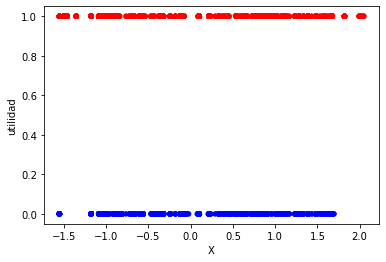

In [8]:
ax = dfDataSetComplete.plot.scatter(x="pedido.data.attributes.age", y="utilidad", c=dfDataSetComplete.utilidad.map({0:'b', 1:'r'}))
dfDataSetComplete.plot.scatter(x="pedido.data.attributes.diagnostic_main", y="utilidad", c=dfDataSetComplete.utilidad.map({0:'b', 1:'r'}), ax=ax)
dfDataSetComplete.plot.scatter(x="respuesta.articlesRevisedMonth", y="utilidad", c=dfDataSetComplete.utilidad.map({0:'b', 1:'r'}), ax=ax)
dfDataSetComplete.plot.scatter(x="respuesta.pubmed_keys", y="utilidad", c=dfDataSetComplete.utilidad.map({0:'b', 1:'r'}), ax=ax)
ax.set_xlabel('X')

A simple vista no podemos crear un hiperplano lineal (division de valores) que nos ayude a poder clasificar los valores del campo utilidad en base los atributos del data set, ya que los resultados del campo "utilidad" estan distribuidos sobre todo el plano de X. Exploraremos con los kernel methods, que metodo nos ayuda a poder crear el hiperplano más optimo para la clasificación

# Exploring Hiper Parameters

· C: el valor de penalització dels errors en la classificació. Indica el compromís entre obtenir l'hiperpla amb el marge més gran possible i classificar el màxim número d'exemples correctament. Provarem valors aleatoris distribuits uniformement entre 1 i 500.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from scipy.stats import uniform as sp_rand
from time import time

clf = svm.SVC()

kernels = ['poly', 'rbf', 'sigmoid']

param_dist = {
    "C":     sp_rand(loc=1, scale=500),
    "gamma": sp_rand(loc=1e-3, scale=1e3)
}

best_score = []

for k in kernels:
    param_dist['kernel'] = [k]
    n_iter_search = 10
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, cv=4)

    start = time()
    random_search.fit(X_train, y_train)
    end = time()
    print("El entrenamiento a durado {} segundos".format(end - start))

    means = random_search.cv_results_["mean_test_score"]
    stds = random_search.cv_results_["std_test_score"]
    params = random_search.cv_results_['params']
    ranks = random_search.cv_results_['rank_test_score']
    best_score.append({'kernel':k,'score':random_search.best_score_, 'params': random_search.best_params_})

    for rank, mean, std, pms in zip(ranks, means, stds, params):
        print("{}) Precision media: {:.2f} +/- {:.2f} con parametros {}".format(rank, mean*100, std*100, pms))
  

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([dic['kernel'] for dic in best_score],[dic['score'] for dic in best_score])
plt.show()

In [ ]:
pd.DataFrame(best_score)

vemos que el kernel que mejor se ajusta al modelo es el radial (rbf). Utilizaremos este kernel con sus correspondientes parametros para entrenar el modelo predictivo